# test to load local package

## try on dataset c20200927 c20201113 in folder SPOTSAR/test_data


In [1]:
# import external packages
import numpy as np
import pandas as pd
import numba
from numba import vectorize
import glob # for file search
import copy
import os # operating system stuff
import re # regex
import fastparquet # fast read/write for large data structures
import sklearn.preprocessing as pre # for data normalisation
from sklearn.metrics import pairwise_distances

import geopandas as gpd
import rasterio as rio
import rasterio.mask
from rasterio.plot import plotting_extent
from shapely.geometry import Polygon
from shapely.geometry.point import Point
import pyproj
from pyproj import CRS
from inpoly import inpoly2 # for fast inpolygon checks
import utm


import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib import cm as mpl_cm
from matplotlib import colors as mcolors 

from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar scaling
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
from matplotlib import rc_file_defaults
rc_file_defaults()
# sns.set(style=None, color_codes=True)



from shapely.geometry import Polygon
from shapely.geometry.point import Point
import datetime

import configparser

from cmcrameri import cm # for scientific colourmaps

###########################
# import main local package
import SPOTSAR_main as sm


In [2]:
import sys
modulenames = set(sys.modules) & set(globals())
allmodules = [sys.modules[name] for name in modulenames]
print(allmodules)

[<module 'glob' from '/Applications/anaconda3/envs/PhD/lib/python3.8/glob.py'>, <module 'rasterio' from '/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/rasterio/__init__.py'>, <module 'sys' (built-in)>, <module 're' from '/Applications/anaconda3/envs/PhD/lib/python3.8/re.py'>, <module 'os' from '/Applications/anaconda3/envs/PhD/lib/python3.8/os.py'>, <module 'datetime' from '/Applications/anaconda3/envs/PhD/lib/python3.8/datetime.py'>, <module 'fastparquet' from '/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/fastparquet/__init__.py'>, <module 'copy' from '/Applications/anaconda3/envs/PhD/lib/python3.8/copy.py'>, <module 'numba' from '/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/numba/__init__.py'>, <module 'pyproj' from '/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/pyproj/__init__.py'>, <module 'configparser' from '/Applications/anaconda3/envs/PhD/lib/python3.8/configparser.py'>, <module 'utm' from '/Applications/anaconda3/en

In [3]:
################ Define user INPUTS #######################
######## please edit the values of this block only ########
###########################################################

# define hillshade file
HS_FILE = './test_data/DEM/TDX_Merapi_WGS84_HS.tif'

# define lon and lat files
LON_FILE = './test_data/CSK_dsc/geo/20200910.lon'
LAT_FILE = './test_data/CSK_dsc/geo/20200910.lat'

# define parameter text file
PARAM_FILE = './test_data/CSK_dsc/params.txt'

# define map region of interest
lon_lims = [110.425, 110.45]
lat_lims = [-7.555, -7.535]

# define colour range {min max} (min = -max)
vmax = 3 # range of colourscale in meters

# define file names for data, lon and lat
DIRECTORY_PATH = "./test_data/CSK_dsc/OFFS/"
# define path to ccp and ccs files
DIRECTORY_PATH_CCS = "./test_data/CSK_dsc/CCS/"

# Set the regular expression pattern to match the file names
PATTERN = r"^c[0-9]+_c[0-9]+_disp_[0-9]+_[0-9]+\.txt$"
# Set the regular expression pattern to match the ccs file names
PATTERN_CCS = r"^c[0-9]+_c[0-9]+_ccs_[0-9]+_[0-9]+$"



In [4]:
# open hillshade file and re-order offset and CCS files

# open hill shade file with rasterio
DEM_HS = rio.open(HS_FILE)
SHADING = DEM_HS.read(1,masked=True) # rasterio bands are indexed from 1

# extract DEM extent
DEM_EXTENT=[DEM_HS.bounds.left,DEM_HS.bounds.right,DEM_HS.bounds.bottom,DEM_HS.bounds.top]

# reorder file using Post_processing.reorder_files
matching_files = sm.Post_processing.reorder_files(DIRECTORY_PATH,PATTERN,0)
matching_files_ccs = sm.Post_processing.reorder_files(DIRECTORY_PATH_CCS,PATTERN_CCS,0)

# test if file ordering has worked
print(matching_files)
print(matching_files_ccs)

['c20200927_c20201113_disp_42_20.txt', 'c20200927_c20201113_disp_74_36.txt', 'c20200927_c20201113_disp_108_52.txt', 'c20200927_c20201113_disp_140_68.txt', 'c20200927_c20201113_disp_174_84.txt', 'c20200927_c20201113_disp_206_100.txt', 'c20200927_c20201113_disp_240_116.txt', 'c20200927_c20201113_disp_272_132.txt', 'c20200927_c20201113_disp_306_148.txt', 'c20200927_c20201113_disp_340_164.txt', 'c20200927_c20201113_disp_372_180.txt']
['c20200927_c20201113_ccs_42_20', 'c20200927_c20201113_ccs_74_36', 'c20200927_c20201113_ccs_108_52', 'c20200927_c20201113_ccs_140_68', 'c20200927_c20201113_ccs_174_84', 'c20200927_c20201113_ccs_206_100', 'c20200927_c20201113_ccs_240_116', 'c20200927_c20201113_ccs_272_132', 'c20200927_c20201113_ccs_306_148', 'c20200927_c20201113_ccs_340_164', 'c20200927_c20201113_ccs_372_180']


In [5]:
# read parameters from text file
config = configparser.ConfigParser()
config.read(PARAM_FILE)
WIDTH = int(config.get('params', 'width'))
LINES = int(config.get('params', 'lines'))
WIDTH_CCS = int(config.get('params', 'width_ccs'))
LINES_CCS = int(config.get('params', 'lines_ccs'))
R_START = int(config.get('params', 'r_start'))
A_START = int(config.get('params', 'a_start'))
R_STEP = int(config.get('params', 'r_step'))
A_STEP = int(config.get('params', 'a_step'))
HEADING = float(config.get('params', 'heading'))
MEAN_INC = float(config.get('params', 'mean_inc'))

In [6]:
# load data from files into classes

datastack = sm.Post_processing.MultiKernel(DIRECTORY_PATH,
                                           matching_files,
                                           DIRECTORY_PATH_CCS,
                                           matching_files_ccs,
                                           LAT_FILE,
                                           LON_FILE,
                                           HEADING,
                                           MEAN_INC,
                                           LINES_CCS,
                                           WIDTH_CCS)
datastack.get_params_from_file_name()
datastack.get_latlon_from_file(WIDTH)
datastack.add_lat_lon_to_data(R_START,A_START)
datastack.crop_stack_ccs(R_STEP,A_STEP)
stacked_data = datastack.assign_data_to_stack(R_STEP,A_STEP)


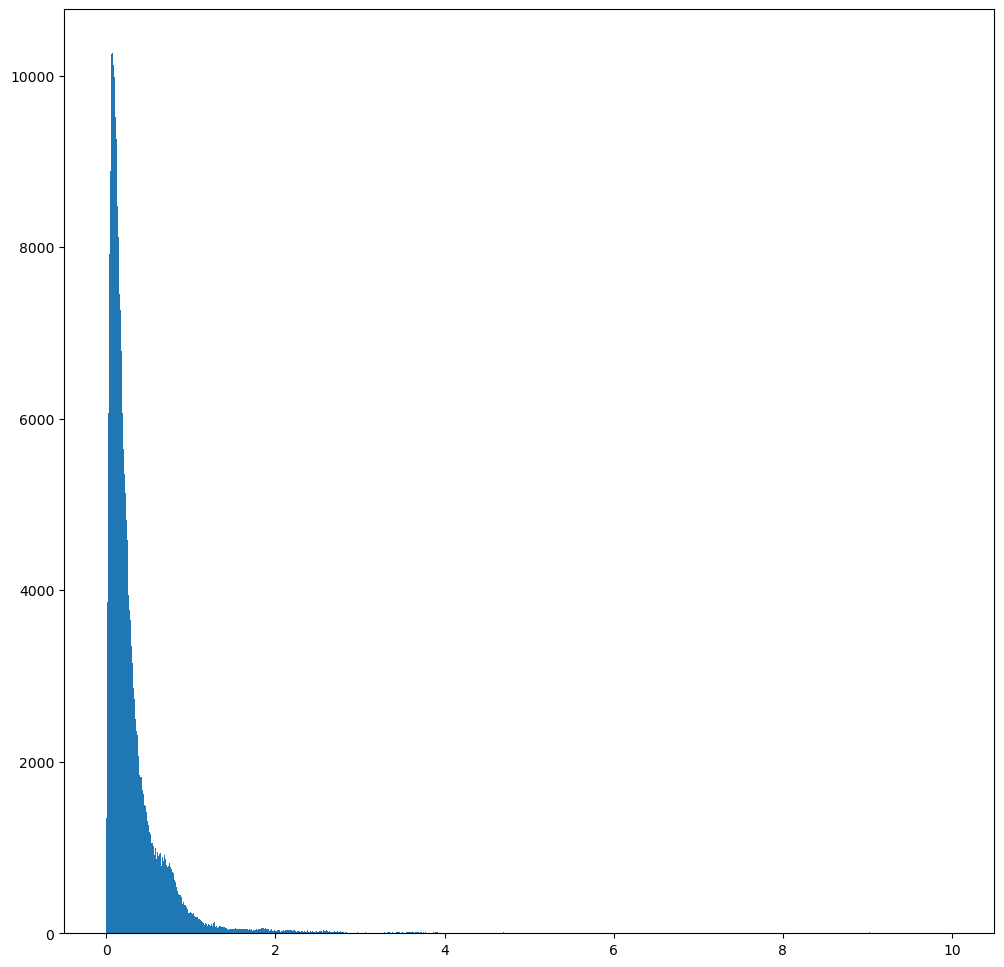

In [7]:
# test some plotting functions
# next to do 8
test_obj = stacked_data[4]
sm.plot.plot_hist(test_obj,'Mag_vec', 1000,[],1, [0,10])
R_off_compare = getattr(test_obj,'R_off')
A_off_compare = getattr(test_obj,'A_off')
lon_off_compare = getattr(test_obj,'Lon_off')
lat_off_compare = getattr(test_obj,'Lat_off')

In [8]:


# # Assuming your 3D array is named 'data_array' with shape (3, M, N)
# # Sheet 0: Data, Sheet 1: X coordinates, Sheet 2: Y coordinates
# data = data_array[0]
# x_coords = data_array[1]
# y_coords = data_array[2]

# window_size = 5

# # Calculate standard deviation using sliding window after removing outliers, removing the plane
# std_result = sliding_window_std(data, x_coords, y_coords, window_size)




In [9]:
# test reshape
data_test = np.reshape(np.array([float(i) for i in range(16)]),(4,4))
data_test[0,1] = np.nan
data_test[1,1] = np.nan
data_test[2,2] = np.nan
data_test[3,0] = np.nan
print(data_test)
window_size = 2
window_shape = (window_size, window_size)
windows = np.lib.stride_tricks.sliding_window_view(data_test, window_shape)
print(windows)
print(np.shape(windows))
d_shape = np.shape(windows)
reshaped_windows = windows.reshape(d_shape[0]*d_shape[1],d_shape[2]*d_shape[3])
# reshaped_windows = reshaped_windows.reshape(d_shape[0]*d_shape[1],d_shape[2]*d_shape[3])

print(reshaped_windows)
print(np.shape(reshaped_windows))

std_test = np.nanstd(reshaped_windows,axis=1)
print(std_test)
# data_r = data.reshape((4,3,2,2))
# print(data_r)
# print(data_r.reshape((12,4)))
plt.close('all')

print(np.nanstd([1.2]))

[[ 0. nan  2.  3.]
 [ 4. nan  6.  7.]
 [ 8.  9. nan 11.]
 [nan 13. 14. 15.]]
[[[[ 0. nan]
   [ 4. nan]]

  [[nan  2.]
   [nan  6.]]

  [[ 2.  3.]
   [ 6.  7.]]]


 [[[ 4. nan]
   [ 8.  9.]]

  [[nan  6.]
   [ 9. nan]]

  [[ 6.  7.]
   [nan 11.]]]


 [[[ 8.  9.]
   [nan 13.]]

  [[ 9. nan]
   [13. 14.]]

  [[nan 11.]
   [14. 15.]]]]
(3, 3, 2, 2)
[[ 0. nan  4. nan]
 [nan  2. nan  6.]
 [ 2.  3.  6.  7.]
 [ 4. nan  8.  9.]
 [nan  6.  9. nan]
 [ 6.  7. nan 11.]
 [ 8.  9. nan 13.]
 [ 9. nan 13. 14.]
 [nan 11. 14. 15.]]
(9, 4)
[2.         2.         2.06155281 2.1602469  1.5        2.1602469
 2.1602469  2.1602469  1.69967317]
0.0


In [19]:
import numpy as np
from numpy.linalg import lstsq
import multiprocessing

from sliding_window_std_functions import sliding_window_std, remove_outliers, remove_plane
### Start of functions

### End of functions

    # test std function 
std_r_list = []
std_a_list = []
deplane = True
data_to_process_r = []
data_to_process_a = []
for obj in datastack.Stack:
    # get data
    offs_R = obj.R_off
    offs_A = obj.A_off
    offs_lon = getattr(obj, 'Lon_off')
    offs_lat = getattr(obj, 'Lat_off')

    data_to_process_r.append((offs_R,offs_lon,offs_lat,5,deplane))
    data_to_process_a.append((offs_A,offs_lon,offs_lat,5,deplane))
# i = 0
# for data in data_to_process_r:
#     print(i)
#     std_r = sliding_window_std(data)
#     std_r_list.append(std_r)
#     i +=1

with multiprocessing.Pool(processes=4) as pool_r:
    results_r = pool_r.map(sliding_window_std, data_to_process_r)

with multiprocessing.Pool(processes=4) as pool_a:
    results_a = pool_a.map(sliding_window_std, data_to_process_a)




removing outliers
removing outliers
removing outliers
removing outliers


/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [ ]:
# for obj in datastack.Stack:
#     # get data
#     offs_R = obj.R_off
#     offs_A = obj.A_off
#     offs_lon = getattr(obj, 'Lon_off')
#     offs_lat = getattr(obj, 'Lat_off')

#     print('starting r')
#     std_r = sliding_window_std(offs_R, offs_lon, offs_lat,5,deplane)
#     print('starting a')
#     std_a = sliding_window_std(offs_A, offs_lon, offs_lat,5,deplane)
#     print('done')

#     std_a[std_a<0] = -1
#     std_r[std_r<0] = -1
#     # fig, ax = plt.subplots(1,2,figsize=(10,10))
#     # std_plot_r= ax[0].imshow(std_r,vmax=np.nanmax(std_r),vmin=0)
#     # std_plot_a= ax[1].imshow(std_a,vmax=np.nanmax(std_a),vmin=0)
#     # plt.colorbar(std_plot_r,ax=ax[0])
#     # plt.colorbar(std_plot_a,ax=ax[1])
#     # ax[0].set_title(f'range offset std ({obj.R_win},{obj.A_win})')
#     # ax[1].set_title(f'azimuth offset std ({obj.R_win},{obj.A_win})')
#     # print(np.nanmin(std_r),np.nanmax(std_r))
#     # print(np.nanmin(std_a),np.nanmax(std_a))
#     std_a_list.append(std_a)
#     std_r_list.append(std_r)

In [15]:
%matplotlib osx
R_offs = [getattr(obj,'R_off') for obj in datastack.Stack]
A_offs = [getattr(obj,'A_off') for obj in datastack.Stack]

# results_r = std_r_list
# results_a = std_r_list


for idx, (std_r_i, std_a_i,R_off,A_off) in enumerate(zip(results_r,results_a,R_offs,A_offs)):
    print(idx)
    fig, ax = plt.subplots(2,2,figsize=(10,10))
    plot_r = ax[0,0].imshow(R_off,vmax=3,vmin=-3,interpolation='nearest',cmap=cm.vik)
    plot_a = ax[0,1].imshow(A_off,vmax=3,vmin=-3,interpolation='nearest',cmap=cm.vik)
    std_plot_r= ax[1,0].imshow(std_r_i,vmax=1,vmin=0,interpolation='nearest')
    std_plot_a= ax[1,1].imshow(std_a_i,vmax=1,vmin=0,interpolation='nearest')
    plt.colorbar(plot_r,ax=ax[0,0])
    plt.colorbar(plot_a,ax=ax[0,1])
    plt.colorbar(std_plot_r,ax=ax[1,0])
    plt.colorbar(std_plot_a,ax=ax[1,1])
    ax[0,0].set_title(f'range offset: {datastack.Stack[idx].R_win},{datastack.Stack[idx].A_win}')
    ax[1,0].set_title(f'range offset std: {datastack.Stack[idx].R_win},{datastack.Stack[idx].A_win}')
    ax[0,1].set_title(f'azimuth offset: {datastack.Stack[idx].R_win},{datastack.Stack[idx].A_win}')
    ax[1,1].set_title(f'azimuth offset std: {datastack.Stack[idx].R_win},{datastack.Stack[idx].A_win}')
    

0
1
2
3
4
5
6
7
8
9
10


In [ ]:
# print(np.sum(np.isnan(std_r_list[0])))
# print(np.sum(np.isnan(R_offs[0])))
# print(np.size(std_r_list[0]))
# print(np.size(R_offs[0]))

import os

os.cpu_count()

In [18]:
mask = ~np.isnan(results_r[10])
r_std_list = [np.nansum(map_r[mask])/np.sum(~np.isnan(map_r[mask])) for map_r in results_r]
a_std_list = [np.nansum(map_a[mask])/np.sum(~np.isnan(map_a[mask])) for map_a in results_a]
n_data = [np.sum(~np.isnan(map_r[mask])) for map_r in results_r]
n_data = n_data/np.max(n_data)

print(r_std_list)
print(a_std_list)

fig, ax = plt.subplots(1,1,figsize = (10,10))
ax.plot(r_std_list)
ax.plot(a_std_list)
ax.plot(np.array(r_std_list)+np.array(a_std_list))
ax.plot(n_data)


[0.24627206889277833, 0.15549784225129554, 0.11092934351419283, 0.08335439219646766, 0.0642002138658901, 0.0530811423163696, 0.04318671612325679, 0.03534013245803418, 0.02938738616356713, 0.025480638631335505, 0.022170723249342012]
[0.3308372455881766, 0.24750508656157197, 0.19040948641565136, 0.1516468252720329, 0.12101674481514363, 0.10015444777186157, 0.08460134545463349, 0.07192659086669079, 0.059425197206630455, 0.050917319673938755, 0.044816070767385925]


1   HIToolbox                           0x00007ff81e4180c2 _ZN15MenuBarInstance22RemoveAutoShowObserverEv + 30
2   HIToolbox                           0x00007ff81e3face3 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1125
3   HIToolbox                           0x00007ff81e3fa7a4 _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 46
4   HIToolbox                           0x00007ff81e3fa762 SetSystemUIMode + 209
5   AppKit                              0x00007ff817f58293 -[NSApplication _setPresentationOptions:instance:flags:] + 1157
6   AppKit                              0x00007ff817dad075 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 614
7   CoreFoundation                      0x00007ff814ac23d4 __CFNOTIFICATIONCENTER_IS_CALLING_OUT_TO_AN_OBSERVER__ + 137
8   CoreFoundation                      0x00007ff814b5c41a ___CFXRegistrationPost_block_invoke + 88
9   CoreFoundation                      0x00007ff814b5c369 _CFXRegistra

In [ ]:
%matplotlib osx
fig, ax = plt.subplots(1,1,figsize=(10,10))
for obj in stacked_data[::-2]:
    sm.plot.plot_hist(obj,'Mag_vec', 1000,(fig,ax), 0.5, [0,4])

In [14]:
plt.close('all')

In [ ]:
import random
import csv
from IPython.display import clear_output
N_test = 200
# get set of random integers for dataset testing:
idx_rand = [random.randint(0,np.size(test_obj.R_off_vec)) for i in range(N_test)]
print(test_obj.R_win, test_obj.A_win)

In [ ]:
%matplotlib inline
# manually check many different vectors to classify as outlier, inlier and confidence on deformation

## make testing data
# store R_idx, A_idx, in/out flag, def flag
# in/out flag:
#   0 : outlier high-confidence0
#   1 : outlier low-confidence
#   2 : inlier low-confidence
#   3 : inlier high confidence 

# def flag:0

#   0 : no def high-confidence
#   1 : no def low-confidence
#   2 : def low-confidence
#   3 : def high confidence 00
0



test_file = f'./test_data/CSK_dsc/{test_obj.R_win}_{test_obj.A_win}_test_set.csv'

init_csv = int(input('initialize csv file?'))

# writing to csv file 
if init_csv == 1:
    with open(test_file, 'w') as csvfile: 
        # creating a csv writer object 
        csvwriter = csv.writer(csvfile) 
            
        # writing the fields 
        csvwriter.writerow(['R idx', 'A idx', 'in/out flag', 'def flag']) 

test_data = []
N_test = 1000
# plt.ion()
counter = 1
for idx in idx_rand:
    if np.mod(counter,10)==0:
        test_data_df = pd.DataFrame(test_data)
        test_data_df.to_csv(test_file, mode='a', index=False, header=False)
        test_data = []
    sm.plot.plot_rand_vec(test_obj,idx,5,0.002,0.3,2)
    plt.show(block=False)
    in_out_flag = int(input('what is the in/out flag? 0:outlier high conf, 1:outlier low conf,  2: inlier low conf, 3: inlier high conf'))
    if in_out_flag not in [0,1,2,3]:
        print('ERROR: flag needs to be 0, 1, 2, or 3')
        break
    def_flag = int(input('what is the def flag? 0: no def high conf, 1: no def low conf., 2: def low conf, 3: def high conf'))
    if in_out_flag not in [0,1,2,3]:
        print('ERROR: flag needs to be 0, 1, 2, or 3')
        break
    test_data.append([test_obj.R_idx_vec[idx], test_obj.A_idx_vec[idx], in_out_flag, def_flag])
    plt.clf()
    clear_output(wait=True)
    counter += 1

test_data = pd.DataFrame(test_data)
test_data.to_csv(test_file, mode='a', index=False, header=False)

In [ ]:
test_data.append([test_obj.R_idx_vec[idx], test_obj.A_idx_vec[idx], in_out_flag, def_flag])
test_data = pd.DataFrame(test_data)
test_data.to_csv(test_file, mode='a', index=False, header=False)

In [ ]:
# print vector field
%matplotlib osx
# sm.plot.plot_vec_attr(test_obj,'Phase',10,50,[0,360],1,shading,DEM_extent)
sm.plot.plot_vec_attr(test_obj,'Phase',5,75,0.005,[0,360],5,SHADING,DEM_EXTENT,[-7.55, -7.53],[110.43,110.46])


In [ ]:
# # test long calculation of local weighted L2
# test_obj.calc_local_L2()


In [ ]:
# plot local dissimilarity vector
# sm.plot.plot_vec_attr(test_obj,'wL2',5 ,50,0.01,[0,5]  ,1,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])


In [ ]:
# test HDBSCAN
min_cluster_size = 16 # smallest minimum cluster size
# compute max overlap
overlap = 4*np.ceil((test_obj.R_win/R_STEP) * (test_obj.A_win/A_STEP))
print(overlap)
min_cluster_size = np.max([int(overlap),min_cluster_size])
min_samples = 1

single_cluster = False # setting to true doesn't break code but makes it run way slower
cluster_selection_epsilon = 0.3 # doesnt do much

In [ ]:
# run HDBSCAN
test_obj.prep_DBSCAN(1,1,100)
test_obj.run_PCA(4)
test_obj.run_HDBSCAN(min_cluster_size,min_samples,single_cluster,cluster_selection_epsilon)

In [ ]:
# plot results from HDBSCAN labels and outlier factor
sm.plot.plot_vec_attr(test_obj,'HDBSCAN_labels',3,50,0.01,[-1,0],5,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])
sm.plot.plot_vec_attr(test_obj,'HDBSCAN_labels',10,50,0.01,[-1,0],5,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])
sm.plot.plot_vec_attr(test_obj,'HDBSCAN_outlier_scores',3,50,0.01,[-1,5],5,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])


In [ ]:
# remove HDBSCAN outliers
# before
sm.plot.plot_vec_attr(test_obj,'Phase',3,50,0.01,[0,360],1,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])
sm.plot.plot_vec_attr(test_obj,'HDBSCAN_outlier_scores',3,50,0.01,[-1,5],1,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])

# remove outliers
test_obj.rem_outliers_HDBSCAN()

# after
sm.plot.plot_vec_attr(test_obj,'Phase',3,50,0.01,[0,360],1,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])
sm.plot.plot_vec_attr(test_obj,'HDBSCAN_outlier_scores',3,50,0.01,[-1,5],1,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])



In [ ]:
# query points
q1 = [110.446216,-7.536389] # stable no veg north
q2 = [110.42647,-7.53297] # stable veg north west
q3 = [110.4421429,-7.5377992] # L1888
q4 = [110.44214,-7.54237] # L1998 large disp
q5 = [110.44013,-7.54678] # stable no veg south
q6 = [110.44200,-7.53604] # L1956 offset gradient
query_points = np.stack((q1,q2,q3,q4,q5,q6))
r = 50

indeces = [0,2,4,6]
stats_list, coordinate_circles = datastack.query_point_stack('R_off_vec',
                                                             query_points[:,1],
                                                             query_points[:,0],
                                                             r,
                                                             indeces)

print(stats_list)

In [ ]:
# 

# cross_plot(test_obj,'HDBSCAN_outlier_scores','wL2',0,300)
# sm.plot.cross_plot(test_obj,'HDBSCAN_outlier_scores','wL2',1,300)

In [ ]:
# plot range offset for different window sizes to see nan mask
indeces = [0,2,4,6]
r_offset = np.stack([obj.R_off for obj in datastack.Stack])
plot_data = [r_offset[idx] for idx in indeces]
plot_data = plot_data + [np.isnan(r_offset[idx]) for idx in range(4)]

cmaps = [cm.vik,cm.vik,cm.vik,cm.vik,
         'Greys','Greys','Greys','Greys']
min_clim = [-vmax,-vmax,-vmax,-vmax,
            0,0,0,0]

max_clim = [vmax,vmax,vmax,vmax,
            1,1,1,1]


# initiate figure
textsize = 15
plt.rc('font', size=textsize) 
fig=plt.figure(figsize=(20,12))
gs=GridSpec(2,4) # 3 rows, 5 columns
axes = [fig.add_subplot(gs[i,j]) for i in range(2) for j in range(4)]

for ax,p_data,cmap,clim_min,clim_max in zip(axes,plot_data,cmaps,min_clim,max_clim):
    ax.imshow(p_data,cmap=cmap,vmin=clim_min,vmax=clim_max, interpolation='Nearest')
    ax.set_axis_off()

In [ ]:
# perfrom outlier detection and removal for all windows
import time
start = time.time()
for obj in stacked_data:
    min_cluster_size = 16 # smallest minimum cluster size
    print(f'current window size: {obj.R_win}, {obj.A_win}')
    overlap = 4*np.ceil((obj.R_win/R_STEP) * (obj.A_win/A_STEP))
    min_cluster_size = np.max([int(overlap),min_cluster_size])
    min_samples = 1
    # run HDBSCAN
    obj.prep_DBSCAN(1,1,100)
    obj.run_PCA(4)
    obj.run_HDBSCAN(min_cluster_size,min_samples,single_cluster,cluster_selection_epsilon)
    obj.rem_outliers_HDBSCAN()
    print(f'time: {time.time()-start}')


In [ ]:
# plot range offset for different window sizes to see nan mask
indeces = [0,2,4,6]
r_offset = np.stack([obj.R_off for obj in datastack.Stack])
plot_data = [r_offset[idx] for idx in indeces]
plot_data = plot_data + [np.isnan(r_offset[idx]) for idx in range(4)]
nan_masks = np.stack([np.isnan(r_offset[idx]) for idx in range(4)])
nan_frac = np.sum(nan_masks, axis=0) / 4

fig=plt.figure(figsize=(7,7))
plt.imshow(nan_frac)
nan_frac2 = copy.deepcopy(nan_frac)
nan_frac2[nan_frac > 0.5] = np.nan
nan_frac2[nan_frac <= 0.5] = 1
fig=plt.figure(figsize=(7,7))
plt.imshow(nan_frac2)

cmaps = [cm.vik,cm.vik,cm.vik,cm.vik,
         'Greys','Greys','Greys','Greys']
min_clim = [-vmax,-vmax,-vmax,-vmax,
            0,0,0,0]

max_clim = [vmax,vmax,vmax,vmax,
            1,1,1,1]


# initiate figure
textsize = 15
plt.rc('font', size=textsize) 
fig=plt.figure(figsize=(20,12))
gs=GridSpec(2,4) # 3 rows, 5 columns
axes = [fig.add_subplot(gs[i,j]) for i in range(2) for j in range(4)]

for ax,p_data,cmap,clim_min,clim_max in zip(axes,plot_data,cmaps,min_clim,max_clim):
    ax.imshow(p_data,cmap=cmap,vmin=clim_min,vmax=clim_max, interpolation='Nearest')
    ax.set_axis_off()

In [ ]:
IMKA_R_off, MKA_A_off = datastack.Run_MKA([0,2,4,6],comp_lim=0.50)

In [ ]:
from sklearn import linear_model
def Run_RSS(stack_obj,indeces=[],window_size=5,deramp=True):
        # """
        # Calculate residual sum of squares. user can specify window size and can turn off deramping if desired

        # Args:
        #     indices (list, optional): indices of slices from datastack used for MKA. Defaults to [], use all data.
        #     window_size (int, optional): window dimension for MKA, odd numbers 
        #                                  prefered because of pixel centering. 
        #                                  Defaults to 5.
        #     deramp (bool, optional): flag for deramping data in map coordinates 
        #                              to allow for better estimates in gradual displacement 
        #                              fields. deramping in map coordinates does not do local 
        #                              transformation to ortholinear projection so there may 
        #                              be inaccuracies. 
        # Returns:
        #     RSS_list: list of resisual sum of squares
        # """
        # get stack data
        if indeces==[]:
            stack_R = [obj.R_off for obj in stack_obj.Stack]
            stack_A = [obj.A_off for obj in stack_obj.Stack]
            stack_lons = [getattr(obj,'Lon_off') for obj in stack_obj.Stack]
            stack_lats = [getattr(obj,'Lat_off') for obj in stack_obj.Stack]

        else:
            substack = [stack_obj.Stack[i] for i in indeces]
            stack_R = np.stack([obj.R_off for obj in substack],axis=0)
            stack_A = np.stack([obj.A_off for obj in substack],axis=0)
            stack_lons = np.stack([getattr(obj,'Lon_off') for obj in substack])
            stack_lats = np.stack([getattr(obj,'Lat_off') for obj in substack])

        # create list of rss values
        rss_list = []

        for stack_r,stack_a,stack_lon,stack_lat in zip(stack_R,stack_A,stack_lons,stack_lats):
            # set window size according to stack dimensions
            window_shape = (window_size, window_size)
            print(np.shape(window_shape))
            # use np.lib.stride_tricks.sliding_window_view to devided data into windows
            # 1.2xfaster than sklearn view_as_windows
            win_data_r = np.lib.stride_tricks.sliding_window_view(stack_r, window_shape)
            win_data_a = np.lib.stride_tricks.sliding_window_view(stack_a, window_shape)

            win_data_lon = np.lib.stride_tricks.sliding_window_view(stack_lon, window_shape)
            win_data_lat = np.lib.stride_tricks.sliding_window_view(stack_lat, window_shape)
            
            # define shape of multi-kernel averaged map (same as input data), filled with nan
            Avg_map_r = []
            Avg_map_a = []



            # per window, go take 95% confidence interval data and take average (mean)
            for win_i in range(win_data_r.shape[0]):
                if win_i % 5 == 0:
                    print('win_i', win_i)
                for win_j in range(win_data_r.shape[1]):
                    # extract relevant window
                    win_rng = np.array(win_data_r[win_i, win_j])
                    win_azi = np.array(win_data_a[win_i, win_j])
                    
                    lon_win = np.array(win_data_lon[win_i,win_j])
                    lat_win = np.array(win_data_lat[win_i,win_j])
                    # print(win_rng,win_azi,lon_win,lat_win)
                    # calculate 95 % confidence interval
                    percentiles_r = np.nanpercentile(win_rng, [2.5, 97.5])
                    percentiles_a = np.nanpercentile(win_azi, [2.5, 97.5])
                    # mask data outside 95% confidence interval with nan
                    mask_r = (win_rng < percentiles_r[0]) | (win_rng > percentiles_r[1])
                    mask_a = (win_azi < percentiles_a[0]) | (win_azi > percentiles_a[1])
                    mask = (mask_r) | (mask_a)
                    # print(mask)
                    win_rng[mask] = np.nan
                    win_azi[mask] = np.nan
                    lon_win[mask] = np.nan
                    lat_win[mask] = np.nan
                    
                    #deramp
                    if np.all(np.isnan(win_rng)):
                        deramped_r = np.nan
                        deramped_a = np.nan
                    else:
                        if deramp:
                            X_data = np.transpose(np.stack((lon_win.flatten(),lat_win.flatten())))
                            Y_data_r = win_rng.flatten()
                            X_data = X_data[np.where(~np.isnan(Y_data_r))]
                            Y_data_r = Y_data_r[np.where(~np.isnan(Y_data_r))]
                            reg = linear_model.LinearRegression().fit(X_data, Y_data_r)
                            deramped_r =win_rng.flatten() - lon_win.flatten() * reg.coef_[0] - lat_win.flatten() * reg.coef_[1]

                            Y_data_a = win_azi.flatten()
                            Y_data_a = Y_data_a[np.where(~np.isnan(Y_data_a))]
                            reg = linear_model.LinearRegression().fit(X_data, Y_data_a)
                            deramped_a =win_azi.flatten() - lon_win.flatten() * reg.coef_[0] - lat_win.flatten() * reg.coef_[1]
                        else:
                            deramped_r = win_rng.flatten()
                            deramped_a = win_azi.flatten()
                    # remove -1 entries (all nans)
                    # deramped_a[deramped_a==-1] = np.nan
                    # deramped_r[deramped_r==-1] = np.nan
            
                    # calculate mean of window (offset by floor(window_size/2) because of border)
                    Avg_map_r.append(np.nanstd(deramped_r)**2)
                    Avg_map_a.append(np.nanstd(deramped_a)**2)
                    
                    rss = (np.sum(Avg_map_r),np.sum(Avg_map_a))
            rss_list.append(rss)
        stack_obj.Rss_list = rss_list

        return stack_obj.Rss_list

In [ ]:
from sklearn import linear_model
import numpy as np

def Run_RSS(stack_obj, indices=[], window_size=5, deramp=True):
    # Get stack data
    if indices == []:
        stack_R = [obj.R_off for obj in stack_obj.Stack]
        stack_A = [obj.A_off for obj in stack_obj.Stack]
        stack_lons = [getattr(obj, 'Lon_off') for obj in stack_obj.Stack]
        stack_lats = [getattr(obj, 'Lat_off') for obj in stack_obj.Stack]
    else:
        substack = [stack_obj.Stack[i] for i in indices]
        stack_R = np.stack([obj.R_off for obj in substack], axis=0)
        stack_A = np.stack([obj.A_off for obj in substack], axis=0)
        stack_lons = np.stack([getattr(obj, 'Lon_off') for obj in substack])
        stack_lats = np.stack([getattr(obj, 'Lat_off') for obj in substack])

    rss_list = []

    for stack_r, stack_a, stack_lon, stack_lat in zip(stack_R, stack_A, stack_lons, stack_lats):
        # Set window size according to stack dimensions
        window_shape = (window_size, window_size)

        # Use np.lib.stride_tricks.sliding_window_view to divide data into windows
        win_data_r = np.lib.stride_tricks.sliding_window_view(stack_r, window_shape)
        win_data_a = np.lib.stride_tricks.sliding_window_view(stack_a, window_shape)
        win_data_lon = np.lib.stride_tricks.sliding_window_view(stack_lon, window_shape)
        win_data_lat = np.lib.stride_tricks.sliding_window_view(stack_lat, window_shape)

        # Define shape of multi-kernel averaged map (same as input data), filled with nan
        Avg_map_r = np.empty(win_data_r.shape[:-2])
        Avg_map_a = np.empty(win_data_a.shape[:-2])

        # Per window, calculate RSS
        for win_i in range(win_data_r.shape[0]):
            if win_i % 5 == 0:
                    print('win_i', win_i)
            for win_j in range(win_data_r.shape[1]):
                win_rng = np.array(win_data_r[win_i, win_j])
                win_azi = np.array(win_data_a[win_i, win_j])
                lon_win = np.array(win_data_lon[win_i, win_j])
                lat_win = np.array(win_data_lat[win_i, win_j])

                # Calculate 95% confidence interval
                percentiles_r = np.nanpercentile(win_rng, [2.5, 97.5])
                percentiles_a = np.nanpercentile(win_azi, [2.5, 97.5])

                # Create mask for values outside confidence interval
                mask_r = (win_rng < percentiles_r[0]) | (win_rng > percentiles_r[1])
                mask_a = (win_azi < percentiles_a[0]) | (win_azi > percentiles_a[1])
                mask = (mask_r) |(mask_a)
                # Mask data outside confidence interval with nan
                win_rng[mask] = np.nan
                win_azi[mask] = np.nan
                lon_win[mask] = np.nan
                lat_win[mask] = np.nan

                if deramp and not np.all(np.isnan(win_rng)):
                    # Deramp data
                    X_data = np.column_stack((lon_win.flatten(), lat_win.flatten()))
                    Y_data_r = win_rng.flatten()
                    Y_data_a = win_azi.flatten()

                    valid_mask_r = ~np.isnan(Y_data_r)
                    valid_mask_a = ~np.isnan(Y_data_a)

                    X_data_r = X_data[valid_mask_r]
                    Y_data_r = Y_data_r[valid_mask_r]

                    X_data_a = X_data[valid_mask_a]
                    Y_data_a = Y_data_a[valid_mask_a]

                    reg_r = linear_model.LinearRegression().fit(X_data_r, Y_data_r)
                    deramped_r = win_rng.flatten() - lon_win.flatten() * reg_r.coef_[0] - lat_win.flatten() * reg_r.coef_[1]

                    reg_a = linear_model.LinearRegression().fit(X_data_a, Y_data_a)
                    deramped_a = win_azi.flatten() - lon_win.flatten() * reg_a.coef_[0] - lat_win.flatten() * reg_a.coef_[1]
                else:
                    deramped_r = win_rng.flatten()
                    deramped_a = win_azi.flatten()

                # Calculate mean of window (offset by floor(window_size/2) because of border)
                np.append(Avg_map_r,np.nanstd(deramped_r)**2)
                np.append(Avg_map_a,np.nanstd(deramped_a)**2)


        rss = (np.sum(Avg_map_r), np.sum(Avg_map_a))
        rss_list.append(rss)

    stack_obj.Rss_list = rss_list
    return stack_obj.Rss_list


In [ ]:
from sklearn import linear_model
import numpy as np

def Run_RSS(stack_obj, indices= [], window_size=5, deramp=True):
    # Get stack data
    if indices == []:
        stack_R = [obj.R_off for obj in stack_obj.Stack]
        stack_A = [obj.A_off for obj in stack_obj.Stack]
        stack_lons = [getattr(obj, 'Lon_off') for obj in stack_obj.Stack]
        stack_lats = [getattr(obj, 'Lat_off') for obj in stack_obj.Stack]
    else:
        substack = [stack_obj.Stack[i] for i in indices]
        stack_R = np.stack([obj.R_off for obj in substack], axis=0)
        stack_A = np.stack([obj.A_off for obj in substack], axis=0)
        stack_lons = np.stack([getattr(obj, 'Lon_off') for obj in substack])
        stack_lats = np.stack([getattr(obj, 'Lat_off') for obj in substack])

    rss_list = []

    for stack_r, stack_a, stack_lon, stack_lat in zip(stack_R, stack_A, stack_lons, stack_lats):
        # Set window size according to stack dimensions
        window_shape = (window_size, window_size)

        # Use np.lib.stride_tricks.sliding_window_view to divide data into windows
        win_data_r = np.array(np.lib.stride_tricks.sliding_window_view(stack_r, window_shape))
        win_data_a = np.array(np.lib.stride_tricks.sliding_window_view(stack_a, window_shape))
        win_data_lon = np.array(np.lib.stride_tricks.sliding_window_view(stack_lon, window_shape))
        win_data_lat = np.array(np.lib.stride_tricks.sliding_window_view(stack_lat, window_shape))

        # Calculate 95% confidence intervals
        percentiles_r = np.nanpercentile(win_data_r, [2.5, 97.5], axis=(2, 3), keepdims=True)
        percentiles_a = np.nanpercentile(win_data_a, [2.5, 97.5], axis=(2, 3), keepdims=True)

        # Create masks for values outside confidence intervals
        mask_r = (win_data_r < percentiles_r[0]) | (win_data_r > percentiles_r[1])
        mask_a = (win_data_a < percentiles_a[0]) | (win_data_a > percentiles_a[1])
        mask = (mask_r) | (mask_a)
        # Mask data outside confidence intervals with nan
        win_data_r[mask] = np.nan
        win_data_a[mask] = np.nan
        win_data_lon[mask] = np.nan
        win_data_lat[mask] = np.nan

        if deramp:
            # Deramp data
            X_data = np.column_stack((win_data_lon.flatten(), win_data_lat.flatten()))
            Y_data_r = win_data_r.flatten()
            Y_data_a = win_data_a.flatten()

            valid_mask = ~np.isnan(Y_data_r)

            X_data = X_data[valid_mask]
            Y_data_r = Y_data_r[valid_mask]
            Y_data_a = Y_data_a[valid_mask]

            reg_r = linear_model.LinearRegression().fit(X_data, Y_data_r)
            reg_a = linear_model.LinearRegression().fit(X_data, Y_data_a)

            deramped_r = Y_data_r - np.dot(X_data, reg_r.coef_)
            deramped_a = Y_data_a - np.dot(X_data, reg_a.coef_)
        else:
            deramped_r = win_data_r.flatten()
            deramped_a = win_data_a.flatten()

        # Calculate mean of window (offset by floor(window_size/2) because of border)
        avg_map_r = np.nanstd(deramped_r)**2
        avg_map_a = np.nanstd(deramped_a)**2

        rss_list.append((np.sum(avg_map_r), np.sum(avg_map_a)))

    stack_obj.Rss_list = rss_list
    return stack_obj.Rss_list


In [ ]:
rss_list = Run_RSS(datastack,[],5,True)

In [ ]:
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar scaling
from cmcrameri import cm

idx_for_plot = [0,2,4,6]
map_extent = [0,446,150,550]
zoom_extent = [140,240,310,390]

substack = [datastack.Stack[i] for i in idx_for_plot]
stack_R = np.stack([obj.R_off for obj in substack],axis=0)
stack_A = np.stack([obj.A_off for obj in substack],axis=0)

plot_data = [stack_R[idx][map_extent[0]:map_extent[1],map_extent[2]:map_extent[3]] for idx in range(len(idx_for_plot))]
plot_data.append(MKA_R_off[map_extent[0]:map_extent[1],map_extent[2]:map_extent[3]])
plot_data = plot_data + [stack_R[idx][zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]] for idx in range(len(idx_for_plot))]
plot_data.append(MKA_R_off[zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]])
plot_data = plot_data + [np.isnan(stack_R[idx][zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]]) for idx in range(len(idx_for_plot))]
plot_data.append(np.isnan(MKA_R_off)[zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]])

cmaps = [cm.vik,cm.vik,cm.vik,cm.vik,cm.vik,
         cm.vik,cm.vik,cm.vik,cm.vik,cm.vik,
         'Greys','Greys','Greys','Greys','Greys',]
min_clim = [-vmax,-vmax,-vmax,-vmax,-vmax,
            -vmax,-vmax,-vmax,-vmax,-vmax,
            0,0,0,0,0,]

max_clim = [vmax,vmax,vmax,vmax,vmax,
            vmax,vmax,vmax,vmax,vmax,
            1,1,1,1,1,]
all_data_arrays2 = [datastack.Stack[idx] for idx in idx_for_plot]
win_sizes = [str(data.get_window_size()) for data in all_data_arrays2]
win_sizes = win_sizes + ['multi-kernel \naverage']


# initiate figure
textsize = 28
plt.rc('font', size=textsize) 
fig=plt.figure(figsize=(10,10))
gs=GridSpec(3,6) # 3 rows, 5 columns
axes = [fig.add_subplot(gs[i,j]) for i in range(3) for j in range(5)]

for ax,p_data,cmap,clim_min,clim_max in zip(axes,plot_data,cmaps,min_clim,max_clim):
    ax.imshow(p_data,cmap=cmap,vmin=clim_min,vmax=clim_max, interpolation='Nearest')
    ax.set_axis_off()
    
for ax,win_size in zip(axes[0:5],win_sizes):
    ax.add_patch(plt.Rectangle((zoom_extent[2]-map_extent[2], zoom_extent[0]-map_extent[0]), zoom_extent[3]-zoom_extent[2], zoom_extent[1]-zoom_extent[0], ls="-", ec="k", fc="none",
                           ))
    ax.set_title(win_size)

fig.tight_layout()
cbar_pos = axes[4].get_position()
 
cax = plt.axes([cbar_pos.x0+cbar_pos.width + 0.1, cbar_pos.y0-0.08, 0.01, 2 * cbar_pos.height])      
mappable = plt.cm.ScalarMappable(cmap = cm.vik,
                                 norm = plt.Normalize(vmin = -vmax, vmax = vmax))
cbar = fig.colorbar(mappable, cax, orientation = 'vertical')
cbar.set_label('Slant range \noffset [m]', rotation=90, loc= 'center',labelpad=0)

# for ax in axes[0:5]:
#     ax.annotate('slant range',xy=(50,50),xytext=(0,-50),textcoords='offset pixels', xycoords='data',
#                     arrowprops=dict(facecolor='black',arrowstyle='<-'),horizontalalignment='center',verticalalignment='top',rotation=90)
#     ax.annotate('azimuth',xy=(50,50),xytext=(50,0),textcoords='offset pixels' ,xycoords='data',
#                     arrowprops=dict(facecolor='black',arrowstyle='<-'),horizontalalignment='left',verticalalignment='center')
textsize = 24
plt.rc('font', size=textsize) 
for ax in axes[-10:-5]:
    ax.annotate('slant range',xy=(5,5),xytext=(0,-50),textcoords='offset pixels', xycoords='data',
                    arrowprops=dict(facecolor='black',arrowstyle='<-',lw=3),horizontalalignment='center',verticalalignment='top',rotation=90)
    ax.annotate('azimuth',xy=(5,5),xytext=(50,0),textcoords='offset pixels' ,xycoords='data',
                    arrowprops=dict(facecolor='black',arrowstyle='<-',lw=3),horizontalalignment='left',verticalalignment='center')

# fig.tight_layout()
fig.subplots_adjust(hspace=0.05)


In [ ]:
plt.close('all')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import rasterio as rio
import fiona
import geopandas as gpd

import json
from shapely.geometry import Point, LineString, mapping
from functools import partial
from shapely.ops import transform


# get NDVI data
file_name = '../Merapi2021/sentinel2/S2A_MSIL2A_20200821T023551_N0214_R089_T49MDM_20200821T064209.SAFE/GRANULE/L2A_T49MDM_A026970_20200821T025827/IMG_DATA/R10m/T49MDM_20200821T023551_NDVI_10m_WGS84.tif'
# with rio.open(file_name) as src:
#     band1 = src.read(1)
#     print('Band1 has shape', band1.shape)
#     height = band1.shape[0]
#     width = band1.shape[1]
#     cols, rows = np.meshgrid(np.arange(width), np.arange(height))
#     xs, ys = rio.transform.xy(src.transform, rows, cols)
#     ndvi_lons = np.array(xs)
#     ndvi_lats = np.array(ys)
#     ndvi_extent = [src.bounds.left,src.bounds.right,src.bounds.bottom,src.bounds.top]


# define map region of interest
lon_lims = [np.nanmin(lon_off_compare), np.nanmax(lon_off_compare)]
lat_lims = [np.nanmin(lat_off_compare), np.nanmax(lat_off_compare)]
crop_flag=1

# create cropping polygon from ROI
if crop_flag:
    coords = ((lon_lims[0], lat_lims[0]), (lon_lims[0], lat_lims[1]), (lon_lims[1], lat_lims[1]), (lon_lims[1], lat_lims[0]), (lon_lims[0], lat_lims[0]))
    crop_poly = Polygon(coords)
    crop_poly_geojson = gpd.GeoSeries([crop_poly])
    crop_poly_geojson.to_file('./test_data/test_variability_roi.shp',crs="EPSG:4326")

with fiona.open('./test_data/test_variability_roi.shp', "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

# get data and read coords from first file
with rio.open(file_name) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open("./test_Data/ndvi_cropped.tif", "w", **out_meta) as dest:
    dest.write(out_image)



with rio.open("./test_Data/ndvi_cropped.tif") as src:
    ndvi_map = src.read(1)
    print('Band1 has shape', ndvi_map.shape)
    height = ndvi_map.shape[0]
    width = ndvi_map.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rio.transform.xy(src.transform, rows, cols)
    ndvi_lons = np.array(xs)
    ndvi_lats = np.array(ys)
    ndvi_extent = [src.bounds.left,src.bounds.right,src.bounds.bottom,src.bounds.top]


x= cm.get_cmap('Blues_r', 135)
y= cm.get_cmap('YlGn', 135)
z = np.vstack((x(range(135)),
                       y(range(135))))
ndvi_cmap = ListedColormap(z, name='BlYlGn')

In [ ]:
# %matplotlib osx

# fig, ax = plt.subplots(1,1,figsize=(10,10))
# ax.imshow(ndvi_map,cmap=ndvi_cmap,extent=ndvi_extent,vmin=-1,vmax=1)

In [ ]:
# test query point

# query points
q1 = [110.446216,-7.536389] # stable no veg north
q2 = [110.42647,-7.53297] # stable veg north west
q3 = [110.4421429,-7.5377992] # L1888
q4 = [110.44214,-7.54237] # L1998 large disp
q5 = [110.44013,-7.54678] # stable no veg south
q6 = [110.44200,-7.53604] # L1956 offset gradient
query_points = np.stack((q1,q2,q3,q4,q5,q6))

r = 50 # radius of 5 meters around point


# original window size 108-52
orig_q_mean, orig_q_median, orig_q_std, orig_q_95, coordinate_circles = sm.Post_processing.query_point(lat_off_compare.flatten(),
                                                               lon_off_compare.flatten(),
                                                               R_off_compare.flatten(),
                                                               query_points[:,1],
                                                               query_points[:,0],
                                                               r)
print('\n')
print(f'Range mean for A, B, C: {orig_q_mean}')
print(f'Range median for A, B, C: {orig_q_median}')
print(f'Range standard deviation for A, B, C: {orig_q_std}')
print(f'Range 95\% confidence interval fro A, B, C: {orig_q_95}')

# MKA reuslt
MKA_q_mean, MKA_q_median, MKA_q_std, MKA_q_95, coordinate_circles = sm.Post_processing.query_point(lat_off_compare.flatten(),
                                                               lon_off_compare.flatten(),
                                                               MKA_R_off.flatten(),
                                                               query_points[:,1],
                                                               query_points[:,0],
                                                               r)
print('\n')
print(f'Range mean for A, B, C: {MKA_q_mean}')
print(f'Range median for A, B, C: {MKA_q_median}')
print(f'Range standard deviation for A, B, C: {MKA_q_std}')
print(f'Range 95\% confidence interval fro A, B, C: {MKA_q_95}')

# original window size 108-52 azimuth
orig_q_mean, orig_q_median, orig_q_std, orig_q_95, coordinate_circles = sm.Post_processing.query_point(lat_off_compare.flatten(),
                                                               lon_off_compare.flatten(),
                                                               A_off_compare.flatten(),
                                                               query_points[:,1],
                                                               query_points[:,0],
                                                               r)
print('\n')
print(f'Azimuth mean for A, B, C: {orig_q_mean}')
print(f'Azimuth median for A, B, C: {orig_q_median}')
print(f'Azimuth standard deviation for A, B, C: {orig_q_std}')
print(f'Azimuth 95\% confidence interval fro A, B, C: {orig_q_95}')

# MKA reuslt
MKA_q_mean, MKA_q_median, MKA_q_std, MKA_q_95, coordinate_circles = sm.Post_processing.query_point(lat_off_compare.flatten(),
                                                               lon_off_compare.flatten(),
                                                               MKA_A_off.flatten(),
                                                               query_points[:,1],
                                                               query_points[:,0],
                                                               r)
print('\n')
print(f'Azimuth mean for A, B, C: {MKA_q_mean}')
print(f'Azimuth median for A, B, C: {MKA_q_median}')
print(f'Azimuth standard deviation for A, B, C: {MKA_q_std}')
print(f'Azimuth 95\% confidence interval fro A, B, C: {MKA_q_95}')


# NDVI reuslt
ndvi_q_mean, ndvi_q_median, ndvi_q_std, ndvi_q_95, coordinate_circles = sm.Post_processing.query_point(ndvi_lats.flatten(),
                                                               ndvi_lons.flatten(),
                                                               ndvi_map.flatten(),
                                                               query_points[:,1],
                                                               query_points[:,0],
                                                               r)
print('\n')
print(f'mean for A, B, C: {ndvi_q_mean}')
print(f'median for A, B, C: {ndvi_q_median}')
print(f'standard deviation for A, B, C: {ndvi_q_std}')
print(f'95\% confidence interval fro A, B, C: {ndvi_q_95}')

In [ ]:
indeces = [0,2,4,6]
stats_list, coordinate_circles = datastack.query_point_stack('A_off_vec',
                                                             query_points[:,1],
                                                             query_points[:,0],
                                                             r,
                                                             indeces)

[q_mean_MKA, q_median_MKA, q_std_MKA, q_95_MKA], coordinate_circles = datastack.query_point_MKA('MKA_A_off',
                                                                                                 query_points[:,1],
                                                                                                 query_points[:,0],
                                                                                                 r)                                                        

In [ ]:
print(stats_list)
# print(q_mean_MKA, q_median_MKA, q_std_MKA, q_95_MKA)
print(MKA_q_mean, MKA_q_median, MKA_q_std, MKA_q_95)

In [ ]:
# make plot for comparison
# 1 original input mid window size
# 2 outlier removed-mka result
# 3 ndvi
from cmcrameri import cm
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

data2plot = [R_off_compare,MKA_R_off,ndvi_map]
lon2plot = [lon_off_compare,lon_off_compare,ndvi_lons]
lat2plot = [lat_off_compare,lat_off_compare,ndvi_lats]
cmaps = [cm.vik,cm.vik,ndvi_cmap]
vmins = [-3,-3,-1]
vmaxs = [3,3,1]
cbar_labels = ['Slant range\noffset [m]', 'Slant range\noffset [m]', 'NDVI [-]']
lon_lims = [110.42, 110.45]
lat_lims = [-7.55, -7.53]
# q1 = [110.446216,-7.536389]
# q2 = [110.427882,-7.530558]
# q3 = [110.4421429,-7.5377992]

distance_meters = sm.plot.get_1deg_dist()


fig, ax = plt.subplots(3,1,figsize=(4,12))
for i,(data,lon_p,lat_p,cmap,vmin,vmax,cbar_label) in enumerate(zip(data2plot,lon2plot,lat2plot,cmaps,vmins,vmaxs,cbar_labels)):
    plot_extent = [np.nanmin(lon_p),np.nanmax(lon_p),np.nanmin(lat_p),np.nanmax(lat_p)]
    plot_data = ax[i].hexbin(lon_p.flatten(),lat_p.flatten(),C=data.flatten(),gridsize=500,cmap=cmap,vmin=vmin,vmax=vmax)
    ax[i].plot(coordinate_circles[0][:,0],coordinate_circles[0][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[1][:,0],coordinate_circles[1][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[2][:,0],coordinate_circles[2][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[3][:,0],coordinate_circles[3][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[4][:,0],coordinate_circles[4][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[5][:,0],coordinate_circles[5][:,1],color='Black',linewidth=3)
    ax[i].set_xlim(lon_lims)
    ax[i].set_ylim(lat_lims)
    ax[i].set_aspect('equal', 'box')
    ax[i].add_artist(ScaleBar(distance_meters,location='lower left'))
    ax[i].set_axis_off()
    cbar = plt.colorbar(plot_data,ax=ax[i])
    cbar.set_label(cbar_label)

In [ ]:
# make plot for comparison
# 1 original input mid window size
# 2 outlier removed-mka result
# 3 ndvi
from cmcrameri import cm
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

data2plot = [R_off_compare,MKA_A_off]
lon2plot = [lon_off_compare,lon_off_compare,lon_off_compare,lon_off_compare]
lat2plot = [lat_off_compare,lat_off_compare,lon_off_compare,lon_off_compare]
cmaps = [cm.vik,cm.vik,cm.vik,cm.vik]
vmins = [-3,-3,-3,-3]
vmaxs = [3,3,3,3]
cbar_labels = ['Slant range\noffset [m]', 'Azimuth\noffset [m]', 'Slant range\noffset [m]', 'Azimuth\noffset [m]',]
lon_lims = [110.42, 110.45]
lat_lims = [-7.55, -7.53]
# q1 = [110.446216,-7.536389]
# q2 = [110.427882,-7.530558]
# q3 = [110.4421429,-7.5377992]

distance_meters = sm.plot.get_1deg_dist()


fig, ax = plt.subplots(2,2,figsize=(12,12))

for (i,j,data,lon_p,lat_p,cmap,vmin,vmax,cbar_label) in zip([0,0,1,1],[0,1,0,1],data2plot,lon2plot,lat2plot,cmaps,vmins,vmaxs,cbar_labels):
    plot_extent = [np.nanmin(lon_p),np.nanmax(lon_p),np.nanmin(lat_p),np.nanmax(lat_p)]
    plot_data = ax[i,j].hexbin(lon_p.flatten(),lat_p.flatten(),C=data.flatten(),gridsize=500,cmap=cmap,vmin=vmin,vmax=vmax)
    # ax[i].plot(coordinate_circles[0][:,0],coordinate_circles[0][:,1],color='Black',linewidth=3)
    # ax[i].plot(coordinate_circles[1][:,0],coordinate_circles[1][:,1],color='Black',linewidth=3)
    # ax[i].plot(coordinate_circles[2][:,0],coordinate_circles[2][:,1],color='Black',linewidth=3)
    # ax[i].plot(coordinate_circles[3][:,0],coordinate_circles[3][:,1],color='Black',linewidth=3)
    # ax[i].plot(coordinate_circles[4][:,0],coordinate_circles[4][:,1],color='Black',linewidth=3)
    # ax[i].plot(coordinate_circles[5][:,0],coordinate_circles[5][:,1],color='Black',linewidth=3)
    ax[i,j].set_xlim(lon_lims)
    ax[i,j].set_ylim(lat_lims)
    ax[i,j].set_aspect('equal', 'box')
    ax[i,j].add_artist(ScaleBar(distance_meters,location='lower left'))
    ax[i,j].set_axis_off()
    cbar = plt.colorbar(plot_data,ax=ax[i,j])
    cbar.set_label(cbar_label)

In [ ]:
# plt.close('all')